# Convolutional NN using TensorFlow

The network is trained on the [CIFAR-10](https://www.cs.utoronto.ca/~kriz/cifar.html) dataset, featuring 32x32 color images labelled into 10 classes, with 50000 training images and 10000 test images.

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import os

tf.enable_eager_execution()

data_path = tf.keras.utils.get_file(fname='cifar10', origin='https://www.cs.utoronto.ca/~kriz/cifar-10-binary.tar.gz', extract=True)
data_dir = os.path.join(os.path.dirname(data_path), 'cifar-10-batches-bin')
train_filenames = tf.convert_to_tensor([os.path.join(data_dir, f'data_batch_{i}.bin') for i in range(1, 6)])
test_filename = tf.convert_to_tensor(os.path.join(data_dir, f'test_batch.bin'))

Records are fixed-length binaries, with the first byte containing the label and the other 3072 bytes dedicated to the image. 

In [2]:
assert tf.executing_eagerly()

record_bytes = (1 + 3 * 32 * 32) # 1 byte per label + 32x32 image with 3 channels

def parse_image_record(raw_bytes):
    raw_bytes = tf.decode_raw(raw_bytes, tf.uint8)
    int_label = tf.reshape(tf.cast(tf.strided_slice(raw_bytes, [0], [1]), tf.int32), shape=())
    # The binary layout of an image is 32 continuous bits (row values) in 32 groups (columns) in 3 groups (channels):
    depth_height_width_img = tf.reshape(tf.strided_slice(raw_bytes, [1], [record_bytes]), [3, 32, 32])
    image = tf.transpose(depth_height_width_img, [1, 2, 0]) # put the image into a [height, width, depth] array
    # Zero-mean normalize images (the average of all values becomes 0) and unit-norm normalize images (the variance becomes 1)
    image = tf.image.per_image_standardization(tf.cast(image, tf.float32))
    return image, int_label

train_dataset = tf.data.FixedLengthRecordDataset(train_filenames, record_bytes).map(parse_image_record)
test_dataset = tf.data.FixedLengthRecordDataset(test_filename, record_bytes).map(parse_image_record)

## Network model

I've attempted to follow the _Strided-CNN-C_ network model described in the [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806) paper. Pooling layers are replaced with strided convolutions, and batch normalization is applied to the first layer (the latter is not used in the original model, but I've found it to improve results when training on <50 batches).

In [3]:
weight_decay = 0.001

l_input = tf.keras.Input(name='input', shape=(32,32,3))

l1_conv = tf.keras.layers.Conv2D(name='l1_conv3x3',
    kernel_size=(3, 3), filters=96, padding='same',
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l_input)

l1_bn = tf.keras.layers.BatchNormalization(name='l1_batchnorm')(l1_conv)
l1 = tf.keras.layers.Activation('relu', name='l1_relu')(l1_bn)

l2 = tf.keras.layers.Conv2D(name='l2_conv3x3_stride2',
    kernel_size=(3, 3), filters=96, strides=2, padding='same',
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l1)

l2_dropout = tf.keras.layers.Dropout(0.5, name='l2_dropout0.5')(l2)

l3 = tf.keras.layers.Conv2D(name='l3_conv3x3',
    kernel_size=(3, 3), filters=192, padding='same',
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l2_dropout)

l4 = tf.keras.layers.Conv2D(name='l4_conv3x3_stride2',
    kernel_size=(3, 3), filters=192, strides=2, padding='same',
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l3)

l4_dropout = tf.keras.layers.Dropout(0.5, name='l4_dropout0.5')(l4)

l5 = tf.keras.layers.Conv2D(name='l5_conv3x3',
    kernel_size=(3, 3), filters=192, padding='same',
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l4_dropout)

l6 = tf.keras.layers.Conv2D(name='l6_conv1x1',
    kernel_size=(1, 1), filters=192, padding='same',
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l5)

l7 = tf.keras.layers.Conv2D(name='l7_conv1x1',
    kernel_size=(1, 1), filters=10, padding='same',
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(l6)

l8 = tf.keras.layers.GlobalAveragePooling2D(name='l8_globalavg')(l7)

l_output = tf.keras.layers.Softmax(axis=-1, name='output_softmax')(l8)

model = tf.keras.Model(inputs=l_input, outputs=l_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
l1_conv3x3 (Conv2D)          (None, 32, 32, 96)        2688      
_________________________________________________________________
l1_batchnorm (BatchNormaliza (None, 32, 32, 96)        384       
_________________________________________________________________
l1_relu (Activation)         (None, 32, 32, 96)        0         
_________________________________________________________________
l2_conv3x3_stride2 (Conv2D)  (None, 16, 16, 96)        83040     
_________________________________________________________________
l2_dropout0.5 (Dropout)      (None, 16, 16, 96)        0         
_________________________________________________________________
l3_conv3x3 (Conv2D)          (None, 16, 16, 192)       166080    
__________

## Optimization

The cost function is *sparse_softmax_cross_entropy_with_logits*, chosen because it does not require the labels to be one-hot encoded. The optimization algorithm is _stochastic gradient descent_ with a fixed momentum of 0.9, as per the paper.

The learning rate is adaptive (starting with 0.021 and multiplied by 0.7 when epoch $\in \{15, 40, 75, 89, 115, 140\}$). The decay is chosen arbitrary and, judging by training results, is suboptimal. It is possible that the rate should not be decreased so early on. Removing it completely, however, results in the accuracy rapidly declining after ~50 epochs.

In [4]:
def loss(model, inputs, target_outputs):
    actual_outputs = model(inputs)
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=target_outputs, logits=actual_outputs))

def gradients(model, inputs, target_outputs):
    with tf.GradientTape() as g:
        loss_value = loss(model, inputs, target_outputs)
    return g.gradient(loss_value, model.variables)

learning_rate = tfe.Variable(0.021)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)

## Training

Training was performed on an NVIDIA Quadro P4000 GPU running in cloud on [Paperspace](https://www.paperspace.com/&R=AZ9IS91).

In [5]:
from time import gmtime, strftime

loss_by_epoch = []
accuracy_by_epoch = []

batched_dataset = train_dataset.batch(32)

with tf.device("/gpu:0"):
    for epoch in range(1, 150):
        if epoch in [15, 40, 75, 90, 115, 140]:
            learning_rate.assign(learning_rate * 0.7)
        
        epoch_loss = tfe.metrics.Mean()
        epoch_accuracy = tfe.metrics.Accuracy()

        for inputs, outputs in batched_dataset:
            grads = gradients(model, inputs, outputs)
            optimizer.apply_gradients(zip(grads, model.variables),
                                      global_step=tf.train.get_or_create_global_step())
            epoch_loss(loss(model, inputs, outputs))
            epoch_accuracy(tf.argmax(model(inputs), axis=1, output_type=tf.int32), outputs)

        loss_by_epoch.append(epoch_loss.result())
        accuracy_by_epoch.append(epoch_accuracy.result())
        
        time = strftime('%H:%M:%S', gmtime())
        print(f'[{time}] Epoch {epoch}, loss: {epoch_loss.result():.3f}, accuracy: {epoch_accuracy.result():.2%}')

[10:54:53] Epoch 1, loss: 2.234, accuracy: 21.58%
[10:55:38] Epoch 2, loss: 2.165, accuracy: 29.19%
[10:56:23] Epoch 3, loss: 2.131, accuracy: 32.71%
[10:57:08] Epoch 4, loss: 2.098, accuracy: 36.00%
[10:57:54] Epoch 5, loss: 2.065, accuracy: 39.58%
[10:58:39] Epoch 6, loss: 2.050, accuracy: 41.00%
[10:59:24] Epoch 7, loss: 2.034, accuracy: 42.69%
[11:00:08] Epoch 8, loss: 2.019, accuracy: 44.20%
[11:00:53] Epoch 9, loss: 2.007, accuracy: 45.39%
[11:01:38] Epoch 10, loss: 1.994, accuracy: 46.72%
[11:02:23] Epoch 11, loss: 1.994, accuracy: 46.84%
[11:03:07] Epoch 12, loss: 1.974, accuracy: 48.81%
[11:03:52] Epoch 13, loss: 1.963, accuracy: 49.85%
[11:04:37] Epoch 14, loss: 1.961, accuracy: 50.10%
[11:05:22] Epoch 15, loss: 1.938, accuracy: 52.36%
[11:06:07] Epoch 16, loss: 1.925, accuracy: 53.70%
[11:06:52] Epoch 17, loss: 1.917, accuracy: 54.58%
[11:07:37] Epoch 18, loss: 1.911, accuracy: 55.15%
[11:08:22] Epoch 19, loss: 1.902, accuracy: 56.00%
[11:09:07] Epoch 20, loss: 1.892, accura

<IPython.core.display.Javascript object>


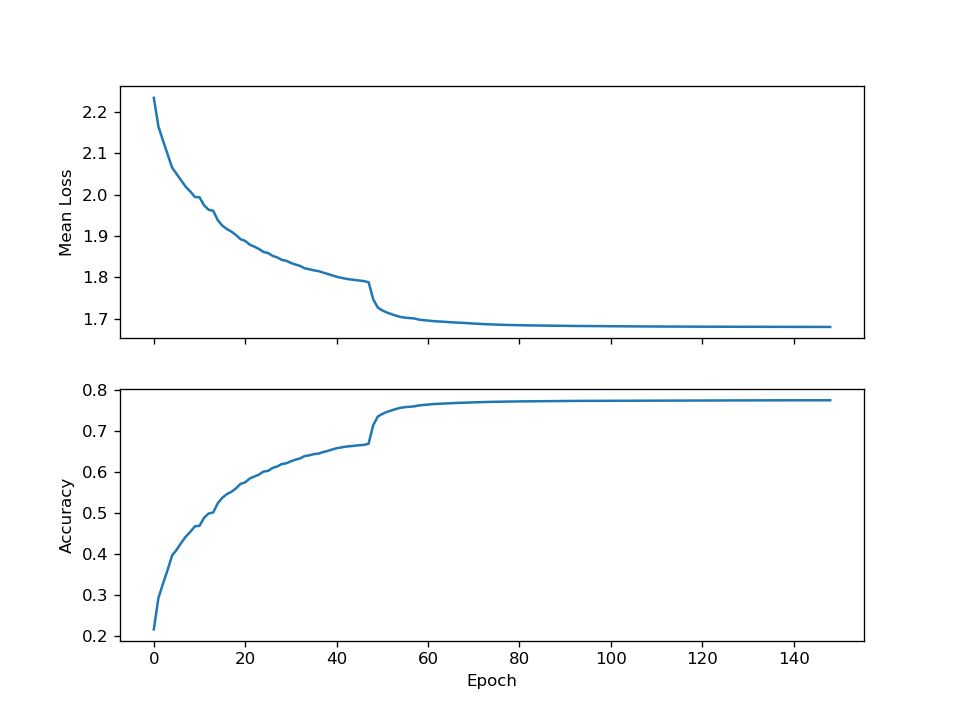

In [6]:
%matplotlib notebook

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(8, 6))

axes[0].set_ylabel('Mean Loss')
axes[0].plot(loss_by_epoch)

axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].plot(accuracy_by_epoch)

plt.show()

## Evaluation

In [7]:
test_accuracy = tfe.metrics.Accuracy()

for inputs, target_outputs in test_dataset.batch(32):
    actual_outputs = tf.argmax(model(inputs), axis=1, output_type=tf.int32)
    test_accuracy(actual_outputs, target_outputs)

print(f'Test accuracy: {test_accuracy.result():.2%}')

Test accuracy: 63.56%
